# IMPORTs

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import glob
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('using device:', device)

d:\workspace\ThesisProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cuda


# FUNCTIONS

In [2]:
def save_model(model, history, model_path, history_path):
    # Save the model state dict
    torch.save(model, model_path)

    save_history_to_csv(history, history_path)

    print(f"Model saved to {model_path}")
    print(f"History saved to {history_path}")

def save_history_to_csv(history, filename):
    df = pd.DataFrame(history)
    df.to_csv(filename, index=False)
    print(f"History saved to {filename}")
    
def load_entire_model(model_path, device):
    # Load the entire model
    model = torch.load(model_path, weights_only=False)
    model.to(device)  # Ensure the model is on the correct device (CPU or GPU)
    print(f"Model loaded from {model_path}")
    
    return model


def plot_history_unet(df, max_epochs):
    # Filter the DataFrame to include only the epochs up to max_epochs
    if isinstance(df['epoch'], range):
        # 'epoch' is a column in the DataFrame
        epochs = list(df['epoch'])[:max_epochs]
        train_losses = df['train_loss'][:max_epochs]
        val_losses = df['val_loss'][:max_epochs]
        train_ious = df['train_iou'][:max_epochs]
        val_ious = df['val_iou'][:max_epochs]
    else:
        # 'epoch' is a range object
        df_filtered = df[df['epoch'] <= max_epochs]
        epochs = df_filtered['epoch']
        train_losses = df_filtered['train_loss']
        val_losses = df_filtered['val_loss']
        train_ious = df_filtered['train_iou']
        val_ious = df_filtered['val_iou']


    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    # Plot IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ious, label='Training IoU', color='blue', marker='o')
    plt.plot(epochs, val_ious, label='Validation IoU', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.grid(True)  # Add grid

    plt.tight_layout()
    plt.show()

def train_model_unet(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # not applied in current training

    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_iou = 0.0  # IoU accumulator for training

        lr = optimizer.param_groups[0]['lr']

            
        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs} lr = {lr}", ncols=100, unit="batch")

        for batch in progress_bar:
            # Access image and mask from the batch (batch is a tuple)
            inputs, labels = batch  # Unpack the tuple into inputs and labels
            # labels = labels.squeeze(2) 
            # Move the tensors to the appropriate device (e.g., GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Make predictions by passing the inputs through the model
            optimizer.zero_grad()  # Clear gradients from the previous step
            outputs = model(inputs)  # Pass inputs through the model
            loss = criterion(outputs, labels)  # Calculate loss

            # Backward pass: Compute gradients and update model weights
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update weights using optimizer

            # Accumulate loss and IoU for this batch
            running_loss += loss.item()
            outputs = outputs.detach().cpu().numpy()  # Detach outputs and move to CPU
            labels = labels.detach().cpu().numpy()  # Detach labels and move to CPU
            iou = compute_iou(outputs, labels)  # IoU calculation
            running_iou += iou

        # Calculate training loss and IoU for the current epoch
        train_loss = running_loss / len(dataloader)
        train_iou = running_iou / len(dataloader)

        # Evaluate the model on the validation set
        val_loss, val_iou = evaluate_model_unet(model, val_dataloader, criterion, device)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        # Print metrics for this epoch
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train IoU={train_iou:.4f}, "
              f"Val Loss={val_loss:.4f}, Val IoU={val_iou:.4f}")

        scheduler.step()  
    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }

    return history  # Return the history dictionary



def compute_iou(preds, labels, threshold=0.5, num_classes=2):
    # preds are probabilities (not logits), threshold them to get binary masks
    preds = (preds > threshold).astype(int)  # Binary thresholding
    
    ious = []
    for i in range(num_classes):  # For each class (0 and 1 for binary segmentation)
        intersection = np.sum((preds == i) & (labels == i))
        union = np.sum((preds == i) | (labels == i))
        iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou)

    return np.mean(ious)

@torch.no_grad()
def evaluate_model_unet(model, val_dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    running_iou = 0.0  # IoU accumulator for validation
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients for validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()

            # For binary segmentation, apply sigmoid and threshold to get binary predictions
            preds = (outputs > 0.5).cpu().numpy()  # Apply threshold for binary classification
            
            # Compute IoU for this batch
            iou = compute_iou(preds, labels.cpu().numpy())
            running_iou += iou

            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    # Calculate mean IoU for the entire validation set
    mean_iou = running_iou / len(val_dataloader)

    # Return the validation loss and mean IoU
    return val_loss / len(val_dataloader), mean_iou

def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df


# U NET

**INITIATE DATASET (AUGMENTED)**

In [49]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from PIL import Image  # Faster than OpenCV

# Constants
SIZE_X, SIZE_Y = 224, 224
BATCH_SIZE = 16  # Reduce batch size for faster loading

# Define Augmentations
image_augmentation = A.Compose([
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

mask_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

normalize_mask_transform = A.Compose([
    A.Resize(SIZE_X, SIZE_Y, interpolation=cv2.INTER_CUBIC),
    ToTensorV2(),
])
normalize_transform = A.Compose([
    A.Resize(SIZE_X, SIZE_Y, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Dataset Paths
image_dir = "./DATASET/TRAIN_UNET/enhanced_images - ESRGAN"
mask_dir = "./DATASET/TRAIN_UNET/mask"

# Get sorted list of images & masks, then zip them together
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
data_pairs = list(zip(image_paths, mask_paths))  # Zipped for direct mapping

assert len(image_paths) == len(mask_paths), "Mismatch in image-mask pairs!"

# Split dataset (70% train, 20% val, 10% test)
train_data, temp_data = train_test_split(data_pairs, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

print(f"Train: {len(train_data)} pairs, Val: {len(val_data)} pairs, Test: {len(test_data)} pairs")

# Optimized Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, data_pairs, apply_augmentation=True):
        self.data_pairs = data_pairs
        self.apply_augmentation = apply_augmentation

        # Duplicate dataset only if augmentation is applied
        self.indices = list(range(len(data_pairs))) * (2 if apply_augmentation else 1)

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image_path, mask_path = self.data_pairs[original_idx]

        # Load using PIL (Faster than OpenCV)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, 0)
        # Apply augmentation only to the augmented part of dataset
        # if idx >= len(self.data_pairs) and self.apply_augmentation == True:
        #     image = image_augmentation(image=image)["image"]
        #     mask = mask_augmentation(image=mask)["image"]


        # Apply normalization and resizing
        image = normalize_transform(image=image)["image"]
        mask = normalize_mask_transform(image=mask)["image"]

        mask = mask / 255.0  # Normalize mask to [0, 1]


        return image, mask.unsqueeze(0)

# Create Train, Validation & Test Datasets
train_dataset = SegmentationDataset(train_data, apply_augmentation=False)
val_dataset = SegmentationDataset(val_data, apply_augmentation=False)
test_dataset = SegmentationDataset(test_data, apply_augmentation=False)

# Optimized DataLoader Settings
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Print final dataset sizes
print(f"Total dataset size: {len(data_pairs)}")
print(f"Train dataset size (with augmentation): {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train: 1679 pairs, Val: 480 pairs, Test: 240 pairs
Total dataset size: 2399
Train dataset size (with augmentation): 1679
Validation dataset size: 480
Test dataset size: 240


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get one sample from the dataset
image, mask = train_dataset[0]  # Change index to see different images

# Convert tensors to NumPy for visualization
image = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
mask = mask.squeeze(0).numpy()  # Remove channel dim

# Plot image and mask side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

mask = mask.squeeze(0)  # Removes the channel dimension (1, H, W) → (H, W)


axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()


NameError: name 'train_dataset' is not defined

**NO AUGMENTATION**

In [3]:
# Constants
import random


SIZE_X, SIZE_Y = 224, 224
BATCH_SIZE = 32

image_transform = transforms.Compose([
    transforms.Resize((SIZE_X, SIZE_Y), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),  # Convert to tensor (H, W, C) -> (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406], [.229, .224, .225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((SIZE_X, SIZE_Y), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),  # Convert mask to tensor
])

def augment_image_and_mask(image, mask, p=0.5):
    # if random.random() < p:
    image = transforms.functional.hflip(image)
    image = transforms.ColorJitter(brightness=0.1)(image)
    mask = transforms.functional.hflip(mask)
    return image, mask

# Dataset Paths
image_dir = "./DATASET/TRAIN_UNET/enhanced_images - ESRGAN"
mask_dir = "./DATASET/TRAIN_UNET/mask"

# Get sorted list of images and masks
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

assert len(image_paths) == len(mask_paths), "Mismatch in image-mask pairs!"

# Split Dataset (80% train, 10% val, 10% test)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure full dataset is used

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size+val_size], image_paths[train_size+val_size:]
train_masks, val_masks, test_masks = mask_paths[:train_size], mask_paths[train_size:train_size+val_size], mask_paths[train_size+val_size:]

# Helper function to load and preprocess images and masks on demand
def load_image(image_path):
    image = cv2.imread(image_path, 1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image)  
    image = image_transform(image)  
    return image

def load_mask(mask_path):
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale (NumPy array)
    mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
    mask = mask_transform(mask)  # Apply transformations
    return mask

def load_augment(image_path, mask_path):
    image = cv2.imread(image_path, 1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image)  
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale (NumPy array)
    mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
    image, mask = augment_image_and_mask(image, mask, p=0.5)  # Apply the same augmentation to both image and mask

    mask = mask_transform(mask)  # Apply transformations
    image = image_transform(image)  

    return image, mask

# DataLoader for train, validation, and test
def create_dataloader(image_paths, mask_paths, batch_size, shuffle, augment=False):
    # Use zip to load images and masks and return a DataLoader

    original_dataset = [(load_image(img_path), load_mask(mask_path)) for img_path, mask_path in zip(image_paths, mask_paths)]
    if augment:
        augmented_dataset = [(load_augment(img_path, mask_path)) for img_path, mask_path in zip(image_paths, mask_paths)]
        original_dataset = augmented_dataset + original_dataset


    # Convert to DataLoader
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1, persistent_workers=True)

# Create DataLoaders
train_loader = create_dataloader(train_paths, train_masks, BATCH_SIZE, True, augment=True)
val_loader = create_dataloader(val_paths, val_masks, BATCH_SIZE, False)
test_loader = create_dataloader(test_paths, test_masks, BATCH_SIZE, False)

# Print dataset sizes
print(f"Total dataset size: {train_loader.dataset.__len__() + val_loader.dataset.__len__() + test_loader.dataset.__len__()}")
print(f"Training set size: {train_loader.dataset.__len__()}")
print(f"Validation set size: {val_loader.dataset.__len__()}")
print(f"Test set size: {test_loader.dataset.__len__()}")


Total dataset size: 4318
Training set size: 3838
Validation set size: 239
Test set size: 241


In [5]:
num_of_batches = 1

for i, (images, masks) in enumerate(train_loader):
    if i == num_of_batches:
        break

    print(f"Batch {i + 1}:")
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    print(f"max pixel value: {images.max()}")
    print(f"min pixel value: {images.min()}")
    print(f"max pixel value: {masks.max()}")  # Should be 1
    print(f"min pixel value: {masks.min()}")  # Should be 0

Batch 1:
Image batch shape: torch.Size([32, 3, 224, 224])
Mask batch shape: torch.Size([32, 1, 224, 224])
max pixel value: 2.640000104904175
min pixel value: -2.1179039478302
max pixel value: 1.0
min pixel value: 0.0


# TRAINING

In [4]:
# LOSS FUNCTIONS
torch.cuda.empty_cache()

focal_loss = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2)
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1e-6)
bce_loss = nn.BCELoss()

epochs = 5 # Number of epochs (change to 30)

l2_lambda = 1e-4
def combined_loss(outputs, labels):
    loss = bce_loss(outputs, labels)

    l2_reg = torch.tensor(0.0, device=outputs.device)
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)
    l2_reg = torch.clamp(l2_reg, max=1.0)


    return loss 

model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",    
    in_channels=3,                  
    classes=1,
    activation='sigmoid'                     
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
history = train_model_unet(model.to(device), train_loader, val_loader, optimizer, combined_loss, epochs=epochs, device=device)


Epoch 1/5 lr = 0.0001: 100%|███████████████████████████████████| 120/120 [01:47<00:00,  1.12batch/s]


Epoch 1/5: Train Loss=1.0911, Train IoU=0.7958, Val Loss=0.9997, Val IoU=0.8985


Epoch 2/5 lr = 0.0001: 100%|███████████████████████████████████| 120/120 [01:42<00:00,  1.17batch/s]


Epoch 2/5: Train Loss=0.9069, Train IoU=0.9178, Val Loss=0.9099, Val IoU=0.9101


Epoch 3/5 lr = 0.0001: 100%|███████████████████████████████████| 120/120 [01:42<00:00,  1.17batch/s]


Epoch 3/5: Train Loss=0.8512, Train IoU=0.9291, Val Loss=0.8696, Val IoU=0.9149


Epoch 4/5 lr = 0.0001: 100%|███████████████████████████████████| 120/120 [01:42<00:00,  1.17batch/s]


Epoch 4/5: Train Loss=0.8229, Train IoU=0.9354, Val Loss=0.8478, Val IoU=0.9193


Epoch 5/5 lr = 0.0001:  28%|█████████▉                          | 33/120 [00:29<01:18,  1.11batch/s]


KeyboardInterrupt: 

# VISUALIZATION

**COMPARE ORIGINAL VS GROUND TRUTH MASK**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].


Image shape: (224, 224, 3)
Mask shape: (224, 224)


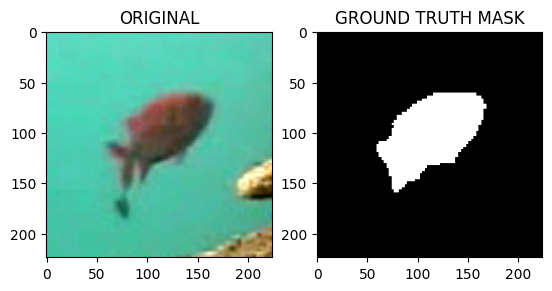

In [7]:
def show_sample(loader):
    # Get a batch of images and masks
    batch = next(iter(loader))
    
    # Access the image and mask tensors from the batch
    images, masks = batch  # Unpack the tuple
    
    # Get the first image and mask from the batch
    image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
    mask = masks[0].squeeze().numpy()  # Remove the single channel and convert to numpy

    # Reverse normalization to bring image back to [0, 1] range for display
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization

    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    
    # Plot image and mask
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("ORIGINAL")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Mask is a single channel image, so use gray colormap
    plt.title("GROUND TRUTH MASK")
    
    plt.show()

# Display sample from training, validation, and test sets
show_sample(train_loader)


**TRAINING GRAPH**

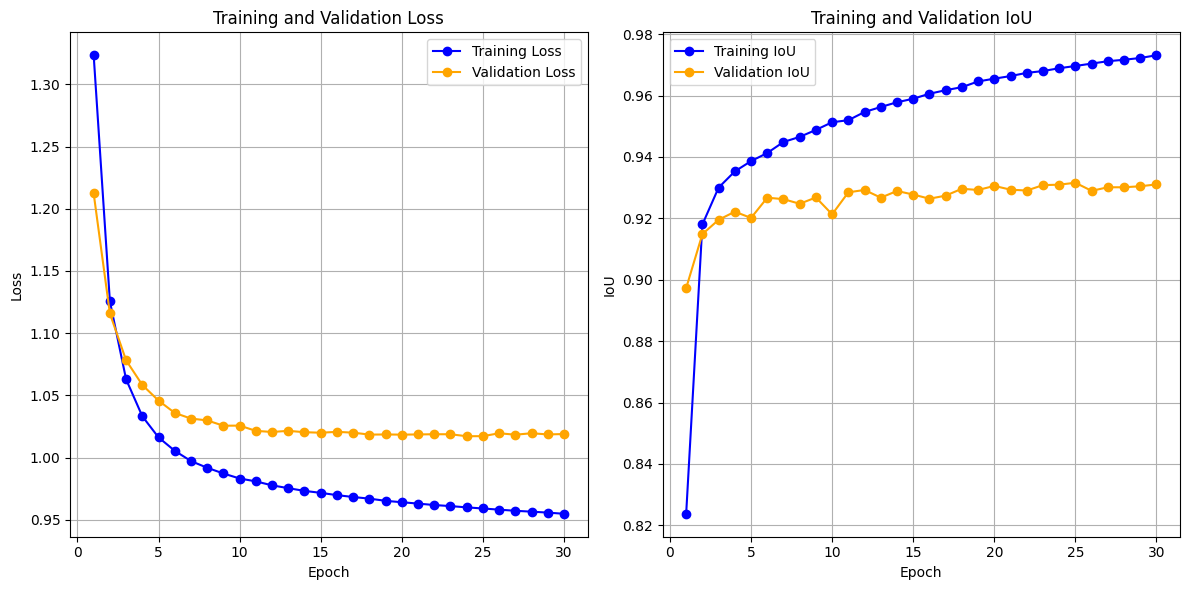

In [10]:
# loaded_history = load_history_from_csv('./saved_models/history/unet_history224-ESRGAN.csv')
plot_history_unet(history, max_epochs=30) # show only first 5 epochs

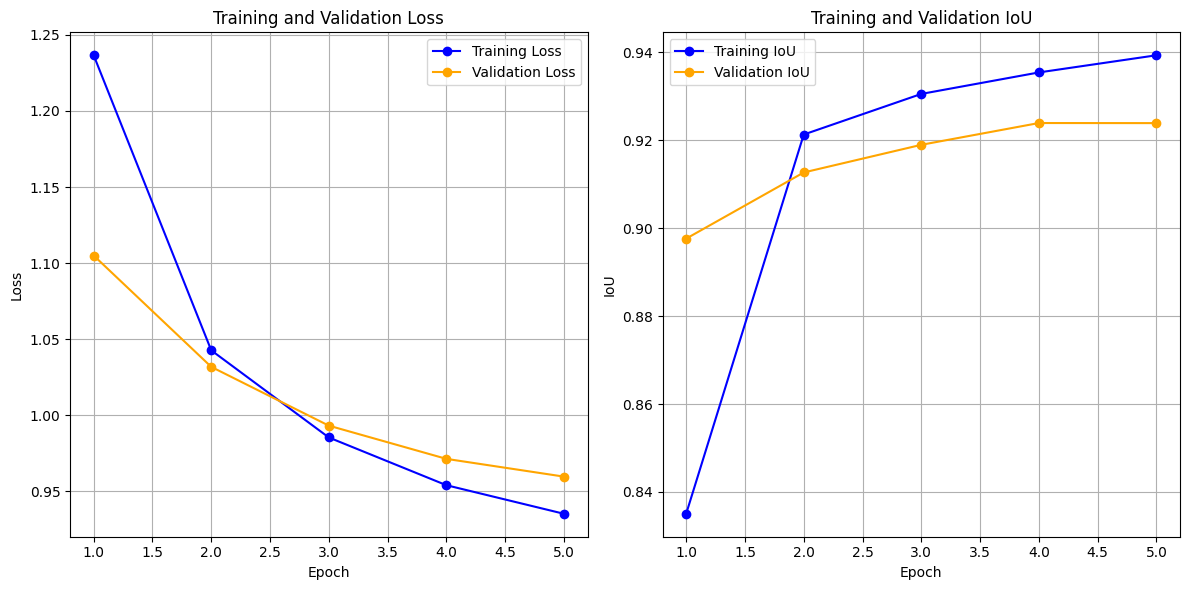

In [8]:
# loaded_history = load_history_from_csv('./saved_models/history/unet_history224-ESRGAN.csv')
plot_history_unet(history, max_epochs=5) # show only first 5 epochs

**FEATURE EXTRACTION**

In [11]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2

# Load an image (example image)
img_path = "./TESTS/images/LR/Acanthurus Nigrofuscus.png"  # Change this to your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_resized = cv2.resize(img, (256, 256))  # Resize to match input size

# Convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize like ImageNet
])

input_tensor = transform(img_resized).unsqueeze(0)  # Add batch dimension

# Move the input tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Get feature maps from the encoder
encoder_layers = model.encoder  # Access ResNet-34 encoder
model.to(device)  # Ensure the model is on the same device

with torch.no_grad():
    x = input_tensor
    feature_maps = []
    for layer in encoder_layers.children():
        x = layer(x)  # Forward pass
        feature_maps.append(x)  # Store feature maps

# Print number of extracted feature maps
for i, fmap in enumerate(feature_maps):
    print(f"Layer {i+1}: {fmap.shape}")  # Shape: (batch_size, channels, height, width)

Layer 1: torch.Size([1, 64, 128, 128])
Layer 2: torch.Size([1, 64, 128, 128])
Layer 3: torch.Size([1, 64, 128, 128])
Layer 4: torch.Size([1, 64, 64, 64])
Layer 5: torch.Size([1, 64, 64, 64])
Layer 6: torch.Size([1, 128, 32, 32])
Layer 7: torch.Size([1, 256, 16, 16])
Layer 8: torch.Size([1, 512, 8, 8])


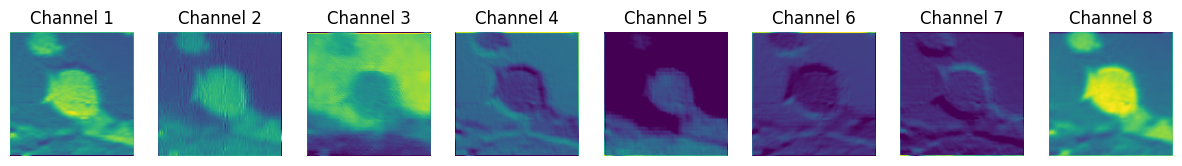

In [12]:
def visualize_feature_maps(feature_maps, layer_idx=0, num_features=6):
    fmap = feature_maps[layer_idx]  # Select layer
    fmap = fmap.squeeze(0)  # Remove batch dimension (C, H, W)

    fig, axes = plt.subplots(1, num_features, figsize=(15, 5))
    for i in range(num_features):
        if i >= fmap.shape[0]:  
            break
        axes[i].imshow(fmap[i].cpu().numpy(), cmap='viridis')
        axes[i].axis("off")
        axes[i].set_title(f"Channel {i+1}")

    plt.show()

# Visualize feature maps from the first ResNet block
visualize_feature_maps(feature_maps, layer_idx=1, num_features=8) # change layer 0-7 or num features


**COMPARE ALL IMAGES VS GROUND TRUTH VS PREDICTED VS MASK**

In [ ]:

SIZE_X, SIZE_Y = 224, 224

# Define paths for input and output directories
input_dirs = {"test": "./DATASET/TEST_ESRGAN2 - ESRGAN"}
output_dirs = {"test": "./DATASET/TEST_ESRGAN2_UNET"}
mask_dir = './DATASET/TRAIN_UNET/mask'

# for split, output_dir in output_dirs.items():
#     os.makedirs(output_dir, exist_ok=True)
#     for species in os.listdir(input_dirs[split]):
#         os.makedirs(os.path.join(output_dir, species), exist_ok=True)

# Parameters
threshold = 0.3  

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]
    mask_filename = f"mask_{fishnumber}.png"
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")
        return None


def preprocess_image(image_path):
    # Read the image
    img = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    
    img = transform(img)
    return img

def process_all(model, device):
    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)
            output_species_dir = os.path.join(output_dir, species)

            display_count = 0

            for img_name in os.listdir(species_dir):
                if display_count >= 5:  # Stop plotting after 5 images
                    break
                print('Image name:', img_name)
                img_path = os.path.join(species_dir, img_name)

                image = preprocess_image(img_path)
                image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

                # Load the ground truth mask (Assuming ground truth masks are stored in a 'masks' folder)
                ground_truth_path = get_corresponding_mask(img_name)
                print(ground_truth_path)
                ground_truth_mask = cv2.imread(ground_truth_path, 0)
                ground_truth_mask = cv2.resize(ground_truth_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_CUBIC)

                with torch.no_grad(): 
                    model.eval()  
                    predicted_mask = model(image)


                predicted_mask = predicted_mask.squeeze().cpu().numpy()
                binary_mask = (predicted_mask > threshold).astype(np.uint8)
                image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
                # Apply the binary mask to the image
                masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)
                masked_image_pred = (masked_image_pred * 255).astype(np.uint8)

                # Display images to inspect each step
                fig, ax = plt.subplots(1, 4, figsize=(16, 8))
                ax[0].imshow(image)  
                ax[0].set_title("Original Image")
                ax[0].axis('off')

                ax[1].imshow(ground_truth_mask, cmap='gray')
                ax[1].set_title("Ground Truth Mask")
                ax[1].axis('off')

                ax[2].imshow(binary_mask, cmap='gray')
                ax[2].set_title("Predicted Binary Mask (Threshold Applied)")
                ax[2].axis('off')

                ax[3].imshow(masked_image_pred)
                ax[3].set_title("Final Masked Image")
                ax[3].axis('off')

                plt.tight_layout()
                plt.show()

                display_count += 1


process_all(model.to(device), device)


# SAVING OR LOADING MODEL

**SAVE**

In [ ]:
save_model(model, history, './saved_models/model/unet_history224-ESRGAN.pth', './saved_models/unet_history224-ESRGAN.csv')

**LOAD**

In [ ]:
model = load_entire_model('./saved_models/model/unet_model224.pth', device)

# SAVING U NET OUTPUT TO DATASET

In [ ]:

SIZE_X, SIZE_Y = 224, 224

# Define paths for input and output directories
input_dirs = {"test": "./DATASET/VALIDATION_ESRGAN2 - ESRGAN"}
output_dirs = {"test": "./DATASET/VALIDATION_ESRGAN2_UNET - ESRGAN"}
mask_dir = './DATASET/TRAIN_UNET/mask'

# Create output directories if they don't exist
for split, output_dir in output_dirs.items():
    os.makedirs(output_dir, exist_ok=True)
    for species in os.listdir(input_dirs[split]):
        os.makedirs(os.path.join(output_dir, species), exist_ok=True)

# Parameters
threshold = 0.3  # Threshold for binary mask

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]
    mask_filename = f"mask_{fishnumber}.png"
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")
        return None


def preprocess_image(image_path):
    # Read the image
    img = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    
    img = transform(img)
    return img

def process_all(model, device):
    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)
            output_species_dir = os.path.join(output_dir, species)

            display_count = 0

            for img_name in os.listdir(species_dir):

                print('Image name:', img_name)
                # Load and preprocess the image
                img_path = os.path.join(species_dir, img_name)

                image = preprocess_image(img_path)
                image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

                # Run the model on the image
                with torch.no_grad():  # No need to compute gradients for inference
                    model.eval()  # Set the model to evaluation mode
                    predicted_mask = model(image)


                # Convert predicted mask to numpy array and apply threshold
                predicted_mask = predicted_mask.squeeze().cpu().numpy()
                binary_mask = (predicted_mask > threshold).astype(np.uint8)
                image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
                # Apply the binary mask to the image
                masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)
                masked_image_pred = (masked_image_pred * 255).astype(np.uint8)

                display_count += 1
                print("masked iamge shape: ", masked_image_pred.shape)
                output_path = os.path.join(output_species_dir, img_name)
                cv2.imwrite(output_path, cv2.cvtColor(masked_image_pred, cv2.COLOR_RGB2BGR))


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

process_all(model.to(device), device)
